# Introdução

Esse projeto tem como objetivo utilizar modelos de inteligência artificial (NLP) para automatizar e classificar os reviews de usuários em scores de 1 a 5.

A Olist é uma startup brasileira que atua no segmento de tecnologia para varejo. A empresa fornece soluções que facilitam a gestão de lojas off-line e online (e-commerce). A Olist concentra vendedores que desejam anunciar em marketplaces como Mercado Livre, Americanas e Amazon, de tal forma que os produtos de todos os vendedores ficam em uma loja única visível ao consumidor final. A empresa possui mais de 30 mil lojistas cadastrados, além de 2 milhões de consumidores únicos a cada ano. ([Wikipédia](https://pt.wikipedia.org/wiki/Olist))

Para esse projeto foi utilizado a base de dados da Olist de avaliações e reviews de produtos comercializados, podendo ser encontrada no [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv).

Para a avaliação de reviews foi escolhido os produtos de Telefonia, no qual resultou em uma amostra com 2050 reviews de produtos de Telefonia.




# Bibliotecas

In [9]:
!pip install --upgrade gensim==4.3.1 scipy==1.12.0 numpy==1.25.2

In [10]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
# Enelvo para normalizacao #https://github.com/thalesbertaglia/enelvo
!pip install enelvo

In [12]:
!pip install torch-summary

In [13]:
# OpenAI para LLM
!pip install openai

In [14]:
# Baixar representação Word2Vec em portugues do nilc cbow 300
!wget http://143.107.183.175:22980/download.php?file=embeddings/wang2vec/cbow_s300.zip -O cbow_s300.zip
!unzip cbow_s300.zip

--2024-12-28 01:42:35--  http://143.107.183.175:22980/download.php?file=embeddings/wang2vec/cbow_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1008563416 (962M) [application/octet-stream]
Saving to: ‘cbow_s300.zip’

cbow_s300.zip       100%[===================>] 961.84M  11.0MB/s    in 89s     

2024-12-28 01:44:05 (10.8 MB/s) - ‘cbow_s300.zip’ saved [1008563416/1008563416]

Archive:  cbow_s300.zip
  inflating: cbow_s300.txt           


In [15]:
# Baixar representação Word2Vec em portugues do nilc skip 300
!wget http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip -O skip_s300.zip
!unzip skip_s300.zip

--2024-12-28 01:44:46--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/octet-stream]
Saving to: ‘skip_s300.zip’

skip_s300.zip       100%[===================>] 914.21M  11.2MB/s    in 83s     

2024-12-28 01:46:09 (11.0 MB/s) - ‘skip_s300.zip’ saved [958619745/958619745]

Archive:  skip_s300.zip
  inflating: skip_s300.txt           


In [16]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import spacy
import torch

from spacy.lang.pt import stop_words
from wordcloud import WordCloud
from enelvo.normaliser import Normaliser
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA

from numpy import triu
from gensim.models import KeyedVectors
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from torchsummary import summary
from openai import OpenAI
from google.colab import drive, userdata as env_colab

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [17]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [18]:
# Pegar a variavel de ambiente do colab que corresponde ao path do projeto no drive
PATH = env_colab.get('PROJECT_PATH')

# Info Datasets e Análise Exploratória

In [19]:
df_olist_order_items = pd.read_csv(PATH+'/data/olist_order_items_dataset.csv', sep=",")
df_olist_order_reviews = pd.read_csv(PATH+'/data/olist_order_reviews_dataset.csv', sep=",")
df_olist_orders = pd.read_csv(PATH+'/data/olist_orders_dataset.csv', sep=",")
df_olist_products = pd.read_csv(PATH+'/data/olist_products_dataset.csv', sep=",")

In [20]:
df_olist_order_items.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [21]:
df_olist_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [22]:
df_olist_orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00


In [23]:
df_olist_products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


In [24]:
df_olist_order_items_products = df_olist_order_items.merge(df_olist_products, on='product_id')

In [25]:
df_olist_orders_join = df_olist_orders.merge(df_olist_order_items_products, on='order_id')

In [26]:
df_olist_orders_join = df_olist_orders_join.merge(df_olist_order_reviews, on='order_id')

In [27]:
df_olist_orders_join.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,500.0,19.0,8.0,13.0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,400.0,19.0,13.0,19.0,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,420.0,24.0,19.0,21.0,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,450.0,30.0,10.0,20.0,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,...,250.0,51.0,15.0,15.0,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [28]:
df_olist_orders_join.iloc[0]

,0
order_id,e481f51cbdc54678b7cc49136f2d6af7
customer_id,9ef432eb6251297304e76186b10a928d
order_status,delivered
order_purchase_timestamp,2017-10-02 10:56:33
order_approved_at,2017-10-02 11:07:15
order_delivered_carrier_date,2017-10-04 19:55:00
order_delivered_customer_date,2017-10-10 21:25:13
order_estimated_delivery_date,2017-10-18 00:00:00
order_item_id,1
product_id,87285b34884572647811a353c7ac498a


In [29]:
df_olist_orders_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112372 non-null  object 
 1   customer_id                    112372 non-null  object 
 2   order_status                   112372 non-null  object 
 3   order_purchase_timestamp       112372 non-null  object 
 4   order_approved_at              112357 non-null  object 
 5   order_delivered_carrier_date   111188 non-null  object 
 6   order_delivered_customer_date  110012 non-null  object 
 7   order_estimated_delivery_date  112372 non-null  object 
 8   order_item_id                  112372 non-null  int64  
 9   product_id                     112372 non-null  object 
 10  seller_id                      112372 non-null  object 
 11  shipping_limit_date            112372 non-null  object 
 12  price                         

In [30]:
df_reviews = df_olist_orders_join[['review_id', 'product_category_name', 'review_score', 'review_comment_title', 'review_comment_message']]

In [31]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_id               112372 non-null  object
 1   product_category_name   110774 non-null  object
 2   review_score            112372 non-null  int64 
 3   review_comment_title    13434 non-null   object
 4   review_comment_message  47642 non-null   object
dtypes: int64(1), object(4)
memory usage: 4.3+ MB


In [32]:
categories = df_reviews['product_category_name'].unique()
print("Tamanho : ", len(categories))
print(categories)

Tamanho :  74
['utilidades_domesticas' 'perfumaria' 'automotivo' 'pet_shop' 'papelaria'
 nan 'moveis_decoracao' 'moveis_escritorio' 'ferramentas_jardim'
 'informatica_acessorios' 'cama_mesa_banho' 'brinquedos' 'telefonia'
 'beleza_saude' 'eletronicos' 'bebes' 'cool_stuff' 'relogios_presentes'
 'climatizacao' 'esporte_lazer' 'livros_interesse_geral'
 'construcao_ferramentas_construcao' 'eletroportateis' 'alimentos'
 'malas_acessorios' 'fashion_underwear_e_moda_praia' 'artigos_de_natal'
 'fashion_bolsas_e_acessorios' 'instrumentos_musicais'
 'construcao_ferramentas_iluminacao' 'livros_tecnicos'
 'construcao_ferramentas_jardim' 'eletrodomesticos' 'market_place'
 'agro_industria_e_comercio' 'artigos_de_festas' 'casa_conforto'
 'cds_dvds_musicais' 'industria_comercio_e_negocios' 'consoles_games'
 'moveis_quarto' 'construcao_ferramentas_seguranca' 'telefonia_fixa'
 'bebidas' 'moveis_cozinha_area_de_servico_jantar_e_jardim'
 'fashion_calcados' 'casa_construcao' 'audio' 'eletrodomesticos_2'
 '

Escolha de telefonia

In [33]:
df_reviews_telefonia = df_reviews.query("product_category_name == 'telefonia'")

In [34]:
df_reviews_telefonia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4517 entries, 17 to 112332
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               4517 non-null   object
 1   product_category_name   4517 non-null   object
 2   review_score            4517 non-null   int64 
 3   review_comment_title    499 non-null    object
 4   review_comment_message  2051 non-null   object
dtypes: int64(1), object(4)
memory usage: 211.7+ KB


In [35]:
df_reviews_telefonia_message_not_null = df_reviews_telefonia[df_reviews_telefonia['review_comment_message'].isna() == False]
df_reviews_telefonia_message_not_null = df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_comment_message'].str.strip().str.len() > 0]
df_reviews_telefonia_message_not_null = df_reviews_telefonia_message_not_null.reset_index(drop=True)

In [36]:
df_reviews_telefonia_message_not_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               2050 non-null   object
 1   product_category_name   2050 non-null   object
 2   review_score            2050 non-null   int64 
 3   review_comment_title    440 non-null    object
 4   review_comment_message  2050 non-null   object
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [37]:
df_reviews_telefonia_message_not_null.head(10)

,review_id,product_category_name,review_score,review_comment_title,review_comment_message
0,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve..."
1,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve..."
2,17800f818523b736983eab6f130be2e3,telefonia,4,NaN,Agora é testar para avaliar se é de qualidade....
3,fa15fd075854d1ca192d11caa066509b,telefonia,4,Ótimo,O produto veio em perfeitas condições e chegou...
4,792972abcdad4e7ac40f11946afabc17,telefonia,5,Excelente,Tudo conforme o combinado!! Entrega antes do p...
5,cfc9d0355db08fa507eeaef4f8c05eb0,telefonia,5,NaN,Solicitei a devolução do pedido!Devido a ter f...
6,d6371e6f7abd7c2c1c6cacfc606802cc,telefonia,3,NaN,Estou tentando ver se os parceiros da stark co...
7,75bafae4aeb5c847a796412f96c8cf38,telefonia,5,muito bom,chegou antes do prazo determinado pela loja.
8,09eb27be1d077ecdf7a3931628bd6a14,telefonia,5,NaN,Produto de excelente qualidade
9,128c507602eef71e8e4ccc5206707507,telefonia,1,NaN,N gostei do produto n era oq imaginei nem oq e...


In [38]:
df_reviews_telefonia_message_not_null['review_score'].unique()

array([1, 4, 5, 3, 2])

O dataset possui 5 scores

In [39]:
df_reviews_telefonia_message_not_null['review_comment_message']

,review_comment_message
0,"Pedir 2 capinhas,estou pagando as duas e só ve..."
1,"Pedir 2 capinhas,estou pagando as duas e só ve..."
2,Agora é testar para avaliar se é de qualidade....
3,O produto veio em perfeitas condições e chegou...
4,Tudo conforme o combinado!! Entrega antes do p...
...,...
2045,"Bem antes da data máxima, ótimo ! Agora é ver ..."
2046,Sensacional compra. Tudo perfeito. Ganhei até ...
2047,"O anúncio é de um combo de 2 produtos, mas vei..."
2048,SIMPLESMENTE NÃO RECEBI O PRODUTO.


In [40]:
df_reviews_telefonia_message_not_null['review_comment_message'].iloc[10]

'Chegou mais rápido que o prazo previsto, fiquei muito feliz com isso. Ja estou usando o produto e gostei muito. Ja comprei outras vezes no baratheon e vou continuar comprando. Site de muita confiança! '

In [41]:
df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == 1]['review_comment_message']

,review_comment_message
0,"Pedir 2 capinhas,estou pagando as duas e só ve..."
1,"Pedir 2 capinhas,estou pagando as duas e só ve..."
9,N gostei do produto n era oq imaginei nem oq e...
20,A película não é de gel. É de plástico e a cap...
25,Recebi um produto diferente do que comprei não...
...,...
2033,entrega feita pelos correios... e um dois apar...
2034,entrega feita pelos correios... e um dois apar...
2043,O produto não foi entregue em que pese já ter ...
2048,SIMPLESMENTE NÃO RECEBI O PRODUTO.


In [42]:
df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == 2]['review_comment_message']

,review_comment_message
13,Os orifícios da capa para conexão do cabo P2 (...
60,Achei demorada a entrega pelo tamanho da merca...
74,Recebi o pedido em 8 dias.
113,Comprei dois produtos e veio só um
114,Comprei dois produtos e veio só um
...,...
2015,"A película não encaixa, não possui o formato d..."
2017,nao recomendo pois faltou a entrega do pelicula
2018,nao recomendo pois faltou a entrega do pelicula
2027,"A Capa não é para esse celular, ela não cabe d..."


In [43]:
df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == 3]['review_comment_message']

,review_comment_message
6,Estou tentando ver se os parceiros da stark co...
17,"O produto em si é bom, mas a entrega deixou mu..."
78,comprei achando que ia servir para o celular s...
79,solicitei a devolução mesmo assim me mandarão ...
85,Regular
...,...
2012,No dia 04/05/2018 Comprei no site das lanniste...
2024,"Como faço para devolver o produto,"
2029,Sem opinião
2031,Entrega atrasada


In [44]:
df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == 4]['review_comment_message']

,review_comment_message
2,Agora é testar para avaliar se é de qualidade....
3,O produto veio em perfeitas condições e chegou...
12,trabalho com profissionalismo das lojas lannis...
30,Produto foi encontrado com um bom preço no sit...
33,"Recebi parcial, faltou a capinha, mas o fornec..."
...,...
2023,Superrecomendo. Ótimo atendimento e bons produ...
2025,o que faltou para a 5ª estrela foi a ausência ...
2030,Bom vendedor
2036,boa boa noite . o tablete esta travando muito\r\n


In [45]:
df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == 5]['review_comment_message']

,review_comment_message
4,Tudo conforme o combinado!! Entrega antes do p...
5,Solicitei a devolução do pedido!Devido a ter f...
7,chegou antes do prazo determinado pela loja.
8,Produto de excelente qualidade
10,"Chegou mais rápido que o prazo previsto, fique..."
...,...
2040,Produto exelente
2041,ótimos preços e produto entregue corretamente ...
2042,produto entregue no prazo e intacto. Obrigado ...
2045,"Bem antes da data máxima, ótimo ! Agora é ver ..."


In [46]:
df_reviews_telefonia_message_not_null.describe()

,review_score
count,2050.000000
mean,3.556098
std,1.610127
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [47]:
quantidade_por_score = list()
for score in range(1,6):
    df_tmp_score = df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null['review_score'] == score]['review_comment_message']
    len_tmp_score = len(df_tmp_score)
    quantidade_por_score.append(len_tmp_score)
    print("-"*10)
    print("Score : ", score)
    print(f"Quantidade de Reviews com score {score}: ", len_tmp_score)
    print(f"Percentual de Reviews com score {score}: ", (len_tmp_score/len(df_reviews_telefonia_message_not_null['review_comment_message']))*100, " %")
    print("Exemplo de Reviews : ", df_tmp_score.iloc[3])
    print("-"*10)
    print("\n")
quantidade_por_score = np.array(quantidade_por_score)
print(f"Quantidade total de reviews : {quantidade_por_score.sum()}")

----------
Score :  1
Quantidade de Reviews com score 1:  453
Percentual de Reviews com score 1:  22.097560975609756  %
Exemplo de Reviews :  A película não é de gel. É de plástico e a capa é de plástico de um material péssimo.

Tive que jogar no lixo.

----------


----------
Score :  2
Quantidade de Reviews com score 2:  130
Percentual de Reviews com score 2:  6.341463414634147  %
Exemplo de Reviews :  Comprei dois produtos e veio só um
----------


----------
Score :  3
Quantidade de Reviews com score 3:  205
Percentual de Reviews com score 3:  10.0  %
Exemplo de Reviews :  solicitei a devolução mesmo assim me mandarão e mandarão errado
----------


----------
Score :  4
Quantidade de Reviews com score 4:  348
Percentual de Reviews com score 4:  16.975609756097562  %
Exemplo de Reviews :  Produto foi encontrado com um bom preço no site e entregue bem rapido. 
----------


----------
Score :  5
Quantidade de Reviews com score 5:  914
Percentual de Reviews com score 5:  44.58536585365

In [48]:
fig = px.bar(
    x=list(range(1, 6)),
    y=quantidade_por_score,
    labels={
        "y": "Quantidade de Reviews",
        "x": "Score"
    },
    title="Quantidade de Reviews por Score"
)
fig.show()

# Funções Comuns para plotar gráficos, wordcloud e pareto

In [49]:
def plot_wordcloud(df, column_text, column_review_score):
    text_wordcloud_geral = " ".join([text for text in df[column_text]])

    df_score1 = df.query(f"{column_review_score} == 1")
    text_wordcloud_score1 = " ".join([text for text in df_score1[column_text]])

    df_score2 = df.query(f"{column_review_score} == 2")
    text_wordcloud_score2 = " ".join([text for text in df_score2[column_text]])

    df_score3 = df.query(f"{column_review_score} == 3")
    text_wordcloud_score3 = " ".join([text for text in df_score3[column_text]])

    df_score4 = df.query(f"{column_review_score} == 4")
    text_wordcloud_score4 = " ".join([text for text in df_score4[column_text]])

    df_score5 = df.query(f"{column_review_score} == 5")
    text_wordcloud_score5 = " ".join([text for text in df_score5[column_text]])

    wordcloud_geral = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_geral)
    wordcloud_score1 = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_score1)
    wordcloud_score2 = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_score2)
    wordcloud_score3 = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_score3)
    wordcloud_score4 = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_score4)
    wordcloud_score5 = WordCloud(max_font_size=200, max_words=1000, background_color="white", width=500, height=500, random_state=42).generate(text_wordcloud_score5)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(wordcloud_geral, interpolation="bilinear")
    axs[0, 0].set_title('Geral')
    axs[0, 0].axis("off")

    axs[0, 1].imshow(wordcloud_score1, interpolation="bilinear")
    axs[0, 1].set_title('Score 1')
    axs[0, 1].axis("off")

    axs[0, 2].imshow(wordcloud_score2, interpolation="bilinear")
    axs[0, 2].set_title('Score 2')
    axs[0, 2].axis("off")

    axs[1, 0].imshow(wordcloud_score3, interpolation="bilinear")
    axs[1, 0].set_title('Score 3')
    axs[1, 0].axis("off")

    axs[1, 1].imshow(wordcloud_score4, interpolation="bilinear")
    axs[1, 1].set_title('Score 4')
    axs[1, 1].axis("off")

    axs[1, 2].imshow(wordcloud_score5, interpolation="bilinear")
    axs[1, 2].set_title('Score 5')
    axs[1, 2].axis("off")

    fig.show()

In [50]:
def _mount_df_freq_pareto(df, column, top_k=20):
    dict_count_token = dict()
    count = 0
    for text in df[column]:
        for doc in nlp(text):
            token = str(doc.text).strip()
            number = dict_count_token.get(token)
            if number is None:
                dict_count_token[token] = 1
            else:
                dict_count_token[token] = number + 1
    df_token_count = pd.DataFrame.from_dict(data=dict_count_token, orient="index", columns=["count"]).sort_values("count", ascending=False)
    df_token_count["cum"] = df_token_count["count"].cumsum()
    df_token_count["percent_cum"] = df_token_count["cum"]/df_token_count["count"].sum()
    return df_token_count

In [51]:
def _plot_pareto(df):
    data = [
        go.Bar(
          name = "Quantidade",
          x= df.index,
          y= df["count"],
          marker= {"color": list(np.repeat('rgb(72, 141, 60)', 10)) + list(np.repeat('rgb(72, 87, 60)', len(df.index) - 10))}
        ),
        go.Scatter(
          line= {
            "color": "rgb(192, 57, 43)", # Vermelho
            "width": 3
          },
          name= "Percentual",
          x=  df.index,
          y= df['percent_cum']*100,
          yaxis= "y2",
          mode='lines+markers'
        ),
    ]

    layout = {

      # titulo
      "title": {
        'text': f"Gráfico de Pareto para Tokens"
      },
      "height": 600,

      # Legend
      "legend": {
        "x": 0.79,
        "y": 1.2,
        'orientation': 'h',
      },

      # Yaxis 1

      "yaxis": {
        "title": f"Quantidade",
        "titlefont": {
        "size": 16,
        "color": "rgb(71, 71, 135)",
        "family": "Courier New, monospace"
        },
      },


      # Yaxis 2
      "yaxis2": {
        "side": "right",
        "range": [0, 100],
        "title": f"Percentual",
        "titlefont": {
          "size": 16,
          "color": "rgb(71, 71, 135)",
          "family": "Courier New, monospace"
        },
        "overlaying": "y",
        "ticksuffix": " %",
      },

    }

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [52]:
def plot_pareto(df, column, top_k=30):
    df_token_count = _mount_df_freq_pareto(df, column)
    _plot_pareto(df_token_count[:top_k])

In [53]:
def plot_pca_score(X, y, title):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    df_components = pd.DataFrame(components)
    df_components["score"] = y
    fig = px.scatter(df_components, x=0, y=1, color='score', title=title)
    fig.show()

def plot_pca_error(X, y_real, y_pred):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    df_components = pd.DataFrame(components)
    df_components["correct"] = (y_real == y_pred)
    fig = px.scatter(df_components, x=0, y=1, color='correct')
    fig.show()

def plot_score_pred_real(X, y_real, y_pred):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    df_components = pd.DataFrame(components)
    df_components["pred"] = y_pred
    df_components["real"] = y_real
    fig = px.scatter(df_components, x=0, y=1, color='pred', facet_col='real')
    fig.show()

In [54]:
def plot_matrix_confusion(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    fig = px.imshow(cm, text_auto=True, labels=dict(x="Predicted", y="True"), x=list(range(1,6)), y=list(range(1,6)))
    fig.show()

In [55]:
def add_metrics_df(model, accuracy, f1, dataframe):
    df = pd.DataFrame([[model, accuracy, f1]],columns=["model", "accuracy", "f1_score"])
    if dataframe is not None:
        df = pd.concat([dataframe, df]).reset_index(drop=True)
    return df

In [56]:
def plot_loss(list_loss_train, list_loss_eval):
    df_tmp_train = pd.DataFrame({"Epochs": list(range(1, NUM_EPOCH+1)), "Loss": list_loss_train})
    df_tmp_train["type"] = "train"
    df_tmp_val = pd.DataFrame({"Epochs": list(range(1, NUM_EPOCH+1)), "Loss": list_loss_eval})
    df_tmp_val["type"] = "val"
    df_tmp = pd.concat([df_tmp_train, df_tmp_val]).reset_index(drop=True)
    fig = px.line(
        df_tmp,
        x="Epochs",
        y="Loss",
        color="type",
        title="Loss"
    )
    fig.show()


def plot_accuracy(list_accuracy_train, list_accuracy_eval):
    df_tmp_train = pd.DataFrame({"Epochs": list(range(1, NUM_EPOCH+1)), "Accuracy": list_accuracy_train})
    df_tmp_train["type"] = "train"
    df_tmp_val = pd.DataFrame({"Epochs": list(range(1, NUM_EPOCH+1)), "Accuracy": list_accuracy_eval})
    df_tmp_val["type"] = "val"
    df_tmp = pd.concat([df_tmp_train, df_tmp_val]).reset_index(drop=True)
    fig = px.line(
        df_tmp,
        x="Epochs",
        y="Accuracy",
        color="type",
        title="Accuracy"
    )
    fig.show()

# Pré-processamento dos dados

Como observamos na análise exploratória, o dataset tem muitos comentários com caracteres especiais, emojis, palavras escritas abreviadas e de forma errada. Assim, iremos utilizar o enelvo a fim de normalizar e corrigir esses dados

In [57]:
norm_enelvo = Normaliser(capitalize_pns=True, capitalize_acs=True, capitalize_inis=True)
sanitize_enelvo = Normaliser(sanitize=True)

def enelvo_normalise(text):
    return norm_enelvo.normalise(text)


def enelvo_sanitize(text):
    return sanitize_enelvo.normalise(text)

In [58]:
df_reviews_telefonia_message_not_null['review_normalise'] = df_reviews_telefonia_message_not_null['review_comment_message'].apply(enelvo_normalise)
df_reviews_telefonia_message_not_null['review_normalise_sanitize'] = df_reviews_telefonia_message_not_null['review_normalise'].apply(enelvo_sanitize)

ERROR:enelvo.normaliser:Failed to normalise word "mercadolivre"!
ERROR:enelvo.normaliser:Failed to normalise word "popsoket"!
ERROR:enelvo.normaliser:Failed to normalise word "turbopower"!
ERROR:enelvo.normaliser:Failed to normalise word "mkkkmkm"!
ERROR:enelvo.normaliser:Failed to normalise word "bbbnbnnn"!
ERROR:enelvo.normaliser:Failed to normalise word "mkkkmkm"!
ERROR:enelvo.normaliser:Failed to normalise word "bbbnbnnn"!
ERROR:enelvo.normaliser:Failed to normalise word "superrecomendo"!
ERROR:enelvo.normaliser:Failed to normalise word "mercadolivre"!
ERROR:enelvo.normaliser:Failed to normalise word "popsoket"!
ERROR:enelvo.normaliser:Failed to normalise word "turbopower"!
ERROR:enelvo.normaliser:Failed to normalise word "mkkkmkm"!
ERROR:enelvo.normaliser:Failed to normalise word "bbbnbnnn"!
ERROR:enelvo.normaliser:Failed to normalise word "mkkkmkm"!
ERROR:enelvo.normaliser:Failed to normalise word "bbbnbnnn"!
ERROR:enelvo.normaliser:Failed to normalise word "appplication"!
ERROR:

In [59]:
df_reviews_telefonia_message_not_null

,review_id,product_category_name,review_score,review_comment_title,review_comment_message,review_normalise,review_normalise_sanitize
0,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve...","Pedir Number capinhas , estou pagando as duas ...",pedir number capinhas estou pagando as duas e ...
1,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve...","Pedir Number capinhas , estou pagando as duas ...",pedir number capinhas estou pagando as duas e ...
2,17800f818523b736983eab6f130be2e3,telefonia,4,NaN,Agora é testar para avaliar se é de qualidade....,Agora é testar para avaliar se é de qualidade ...,agora é testar para avaliar se é de qualidade ...
3,fa15fd075854d1ca192d11caa066509b,telefonia,4,Ótimo,O produto veio em perfeitas condições e chegou...,O produto veio em perfeitas condições e chegou...,o produto veio em perfeitas condições e chegou...
4,792972abcdad4e7ac40f11946afabc17,telefonia,5,Excelente,Tudo conforme o combinado!! Entrega antes do p...,Tudo conforme o combinado ! ! Entrega antes do...,tudo conforme o combinado entrega antes do pra...
...,...,...,...,...,...,...,...
2045,687d151c5fac1c42975fb986081b2aaa,telefonia,5,NaN,"Bem antes da data máxima, ótimo ! Agora é ver ...","Bem antes da data máxima , ótimo ! Agora é ver...",bem antes da data máxima ótimo agora é ver se ...
2046,f2ab136899d66379c081ff7df3a49764,telefonia,5,Impecável,Sensacional compra. Tudo perfeito. Ganhei até ...,Sensacional compra . Tudo perfeito . Ganhei at...,sensacional compra tudo perfeito ganhei até br...
2047,41d1f817a158fe835109e49823d07868,telefonia,2,NaN,"O anúncio é de um combo de 2 produtos, mas vei...","O anúncio é de um Combo de Number produtos , m...",o anúncio é de um combo de number produtos mas...
2048,ae0039085c486a7c94314c9430789af6,telefonia,1,NaN,SIMPLESMENTE NÃO RECEBI O PRODUTO.,Simplesmente não recebi o produto .,simplesmente não recebi o produto


In [60]:
# Carregar Spacy Portugues
nlp = spacy.load("pt_core_news_sm")

In [61]:
# Quantidade de StopWords
len(stop_words.STOP_WORDS)

416

In [62]:
"não" in stop_words.STOP_WORDS

True

O não é fundamental, pois tem o sentido negativo em scores ruins, logo tiraremos ela das stopwords.

In [63]:
def clean_word(words):
    list_clean = list()
    for doc in nlp(words):
        if (doc.is_stop and str(doc.text).lower() != "não") or not(doc.is_alpha) or doc.is_digit or doc.is_currency or doc.is_quote or doc.is_punct or doc.like_email or doc.like_num or doc.like_url:
            continue
        else:
            text = doc.text
            #if doc.is_sent_start is True:
            #    text = str(text).capitalize()
            #else:
            text = str(text).lower()
            list_clean.append(text)
    text = " ".join(list_clean)
    if len(str(text).strip()) > 0:
        return text
    else:
        return None

In [64]:
df_reviews_telefonia_message_not_null['review_normalise_clean'] = df_reviews_telefonia_message_not_null['review_normalise_sanitize'].apply(clean_word)

In [65]:
df_reviews_telefonia_message_not_null

,review_id,product_category_name,review_score,review_comment_title,review_comment_message,review_normalise,review_normalise_sanitize,review_normalise_clean
0,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve...","Pedir Number capinhas , estou pagando as duas ...",pedir number capinhas estou pagando as duas e ...,pedir number capinhas pagando veio não satisfe...
1,4ff7c437ae60fa0b3c700ade55155027,telefonia,1,NaN,"Pedir 2 capinhas,estou pagando as duas e só ve...","Pedir Number capinhas , estou pagando as duas ...",pedir number capinhas estou pagando as duas e ...,pedir number capinhas pagando veio não satisfe...
2,17800f818523b736983eab6f130be2e3,telefonia,4,NaN,Agora é testar para avaliar se é de qualidade....,Agora é testar para avaliar se é de qualidade ...,agora é testar para avaliar se é de qualidade ...,testar avaliar qualidade certo
3,fa15fd075854d1ca192d11caa066509b,telefonia,4,Ótimo,O produto veio em perfeitas condições e chegou...,O produto veio em perfeitas condições e chegou...,o produto veio em perfeitas condições e chegou...,produto veio perfeitas condições chegou prazo ...
4,792972abcdad4e7ac40f11946afabc17,telefonia,5,Excelente,Tudo conforme o combinado!! Entrega antes do p...,Tudo conforme o combinado ! ! Entrega antes do...,tudo conforme o combinado entrega antes do pra...,conforme combinado entrega prazo ficamos feliz...
...,...,...,...,...,...,...,...,...
2045,687d151c5fac1c42975fb986081b2aaa,telefonia,5,NaN,"Bem antes da data máxima, ótimo ! Agora é ver ...","Bem antes da data máxima , ótimo ! Agora é ver...",bem antes da data máxima ótimo agora é ver se ...,data máxima ótimo aparelho funciona
2046,f2ab136899d66379c081ff7df3a49764,telefonia,5,Impecável,Sensacional compra. Tudo perfeito. Ganhei até ...,Sensacional compra . Tudo perfeito . Ganhei at...,sensacional compra tudo perfeito ganhei até br...,sensacional compra perfeito ganhei brinde reco...
2047,41d1f817a158fe835109e49823d07868,telefonia,2,NaN,"O anúncio é de um combo de 2 produtos, mas vei...","O anúncio é de um Combo de Number produtos , m...",o anúncio é de um combo de number produtos mas...,anúncio combo number produtos veio
2048,ae0039085c486a7c94314c9430789af6,telefonia,1,NaN,SIMPLESMENTE NÃO RECEBI O PRODUTO.,Simplesmente não recebi o produto .,simplesmente não recebi o produto,simplesmente não recebi produto


In [66]:
df_reviews_telefonia_message_not_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   review_id                  2050 non-null   object
 1   product_category_name      2050 non-null   object
 2   review_score               2050 non-null   int64 
 3   review_comment_title       440 non-null    object
 4   review_comment_message     2050 non-null   object
 5   review_normalise           2050 non-null   object
 6   review_normalise_sanitize  2050 non-null   object
 7   review_normalise_clean     1987 non-null   object
dtypes: int64(1), object(7)
memory usage: 128.2+ KB


In [67]:
df_reviews_telefonia_message_not_null = df_reviews_telefonia_message_not_null[df_reviews_telefonia_message_not_null["review_normalise_clean"].isna() == False]

In [68]:
df_reviews_telefonia_message_not_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 2049
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   review_id                  1987 non-null   object
 1   product_category_name      1987 non-null   object
 2   review_score               1987 non-null   int64 
 3   review_comment_title       432 non-null    object
 4   review_comment_message     1987 non-null   object
 5   review_normalise           1987 non-null   object
 6   review_normalise_sanitize  1987 non-null   object
 7   review_normalise_clean     1987 non-null   object
dtypes: int64(1), object(7)
memory usage: 139.7+ KB


# EDA - Pareto e WordCloud

## Wordcloud

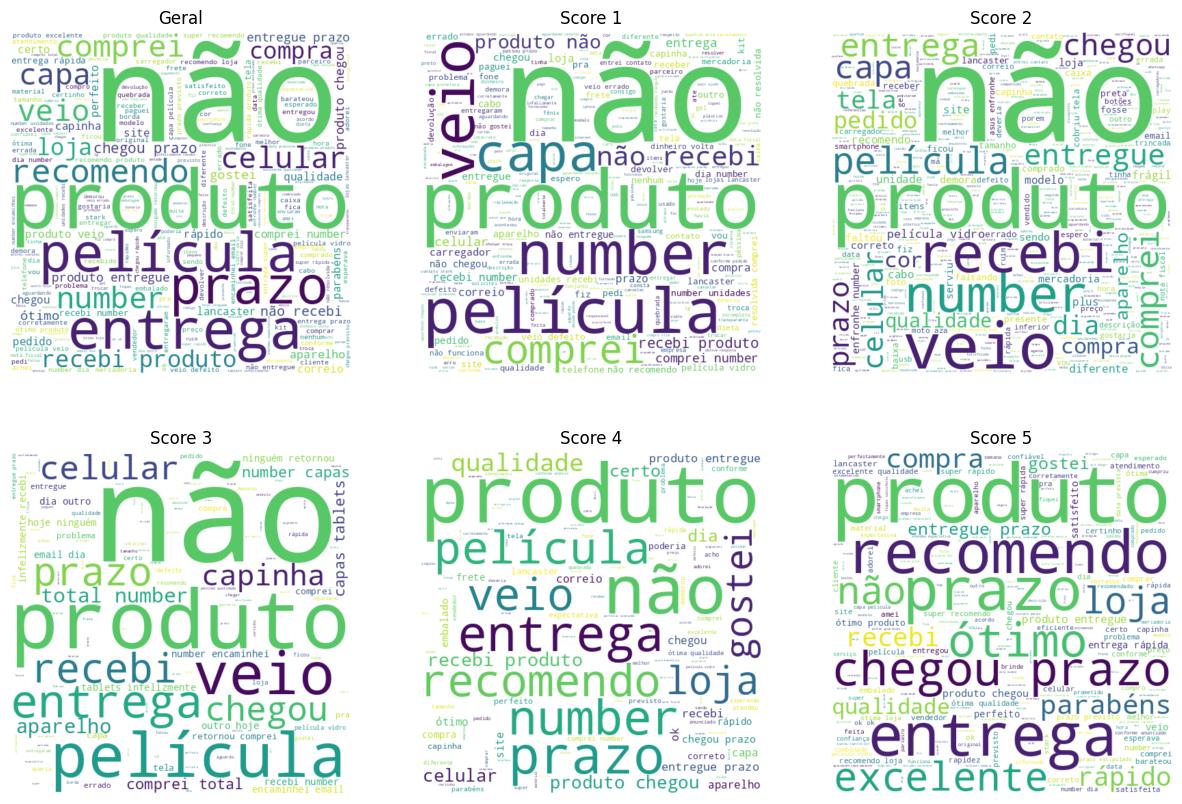

In [69]:
plot_wordcloud(df_reviews_telefonia_message_not_null, "review_normalise_clean", "review_score")

Podemos perceber que em scores mais perto de 5 o não diminui sua quantidade e importância no score. Quando temos o score mais alto percebemos o surgimento de outras palavras de elogio, tais como gostei, recomendo, ótimo, excelente, rápido, parábens, qualidade, dentre outras.

## Pareto

### Geral

In [70]:
plot_pareto(df=df_reviews_telefonia_message_not_null, column="review_normalise_clean", top_k=300)

### Score 1

In [71]:
plot_pareto(df=df_reviews_telefonia_message_not_null.query("review_score == 1"), column="review_normalise_clean", top_k=25)

### Score 2

In [72]:
plot_pareto(df=df_reviews_telefonia_message_not_null.query("review_score == 2"), column="review_normalise_clean", top_k=25)

### Score 3

In [73]:
plot_pareto(df=df_reviews_telefonia_message_not_null.query("review_score == 3"), column="review_normalise_clean", top_k=25)

### Score 4

In [74]:
plot_pareto(df=df_reviews_telefonia_message_not_null.query("review_score == 4"), column="review_normalise_clean", top_k=25)

### Score 5

In [75]:
plot_pareto(df=df_reviews_telefonia_message_not_null.query("review_score == 5"), column="review_normalise_clean", top_k=25)

# Modelos

In [76]:
df_results = pd.DataFrame(columns=["model", "accuracy", "f1_score"])

In [77]:
cbow = KeyedVectors.load_word2vec_format("cbow_s300.txt")
skip = KeyedVectors.load_word2vec_format("skip_s300.txt")
def _embedding(text, model):
    vector = None
    for doc in nlp(text):
        if vector is None:
            try:
                vector = model[doc.text]
            except:
                vector = model["unk"]
        else:
            try:
                vector = vector + model[doc.text]
            except:
                vector = vector + model["unk"]
    return pd.Series(vector)

def embedding_cbow(text):
    return _embedding(text, cbow)

def embedding_skip(text):
    return _embedding(text, skip)

In [78]:
df_preprocessing_model = df_reviews_telefonia_message_not_null[["review_comment_message", "review_normalise", "review_normalise_sanitize" ,"review_normalise_clean", "review_score"]]

In [79]:
# Dividir dataset treino, validacao e teste
X_train, X_val_test, y_train, y_val_test = train_test_split(df_preprocessing_model.drop(columns="review_score"), df_preprocessing_model["review_score"],train_size=0.7, random_state=RANDOM_STATE)
X_train = X_train.reset_index(drop=True)
X_val_test = X_val_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val_test = y_val_test.reset_index(drop=True)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_STATE)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## SVM + BoW

In [80]:
# Train
bow = CountVectorizer(strip_accents="unicode")

bow = bow.fit(X_train["review_normalise_clean"])
x_train_preprocessing = bow.transform(X_train["review_normalise_clean"])

svm = SVC(random_state=RANDOM_STATE)
svm = svm.fit(x_train_preprocessing, y_train)
pred_train = svm.predict(x_train_preprocessing)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.83      0.92      0.87       323
           2       1.00      0.66      0.80        92
           3       0.99      0.58      0.73       130
           4       1.00      0.40      0.57       234
           5       0.75      0.99      0.85       611

    accuracy                           0.81      1390
   macro avg       0.91      0.71      0.76      1390
weighted avg       0.85      0.81      0.80      1390



In [81]:
plot_pca_score(x_train_preprocessing, y_train, "Score Base")

In [82]:
# Validacao
x_val_preprocessing = bow.transform(X_val["review_normalise_clean"])
pred_val = svm.predict(x_val_preprocessing)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.47      0.77      0.59        60
           2       1.00      0.10      0.17        21
           3       0.33      0.03      0.05        34
           4       1.00      0.06      0.12        48
           5       0.67      0.96      0.79       135

    accuracy                           0.61       298
   macro avg       0.70      0.38      0.34       298
weighted avg       0.67      0.61      0.51       298



In [83]:
# Teste
x_test_preprocessing = bow.transform(X_test["review_normalise_clean"])
pred_test = svm.predict(x_test_preprocessing)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("SVM + BoW", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.53      0.81      0.64        69
           2       1.00      0.06      0.12        16
           3       0.71      0.15      0.25        33
           4       0.33      0.02      0.04        48
           5       0.67      0.92      0.78       133

    accuracy                           0.62       299
   macro avg       0.65      0.39      0.37       299
weighted avg       0.61      0.62      0.54       299



<ipython-input-55-e24ec7b16597>:4: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [84]:
plot_matrix_confusion(y_test, pred_test)

In [85]:
plot_pca_error(x_test_preprocessing, y_test, pred_test)

In [86]:
plot_pca_score(x_test_preprocessing, y_test, "Score Real")
plot_pca_score(x_test_preprocessing, pred_test, "Score Pred")

In [87]:
plot_score_pred_real(x_test_preprocessing, y_test, pred_test)

## SVM + TFIDF

In [88]:
# Train
tfidf = TfidfVectorizer(strip_accents="unicode")

tfidf = tfidf.fit(X_train["review_normalise_clean"])
x_train_preprocessing = tfidf.transform(X_train["review_normalise_clean"])

svm = SVC(random_state=RANDOM_STATE)
svm = svm.fit(x_train_preprocessing, y_train)
pred_train = svm.predict(x_train_preprocessing)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.88      0.99      0.93       323
           2       1.00      0.70      0.82        92
           3       1.00      0.80      0.89       130
           4       0.97      0.61      0.75       234
           5       0.86      0.99      0.92       611

    accuracy                           0.89      1390
   macro avg       0.94      0.82      0.86      1390
weighted avg       0.90      0.89      0.88      1390



In [89]:
plot_pca_score(x_train_preprocessing, y_train, "Score Base")

In [90]:
# Validacao
x_val_preprocessing = tfidf.transform(X_val["review_normalise_clean"])
pred_val = svm.predict(x_val_preprocessing)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.53      0.87      0.65        60
           2       0.67      0.10      0.17        21
           3       1.00      0.03      0.06        34
           4       0.57      0.08      0.15        48
           5       0.68      0.95      0.79       135

    accuracy                           0.63       298
   macro avg       0.69      0.40      0.36       298
weighted avg       0.67      0.63      0.53       298



In [91]:
# Teste
x_test_preprocessing = tfidf.transform(X_test["review_normalise_clean"])
pred_test = svm.predict(x_test_preprocessing)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("SVM + TFIDF unigrams", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.60      0.88      0.71        69
           2       0.00      0.00      0.00        16
           3       0.80      0.12      0.21        33
           4       0.33      0.06      0.11        48
           5       0.68      0.94      0.79       133

    accuracy                           0.65       299
   macro avg       0.48      0.40      0.36       299
weighted avg       0.58      0.65      0.56       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [92]:
plot_matrix_confusion(y_test, pred_test)

Podemos notar que o modelo consegue distiguir bem o score máximo (5) e o mínimo (1), mas os demais scores o modelo classifica erroneamente.

In [93]:
plot_pca_error(x_test_preprocessing, y_test, pred_test)

In [94]:
plot_pca_score(x_test_preprocessing, y_test, "Score Real")
plot_pca_score(x_test_preprocessing, pred_test, "Score Pred")

In [95]:
plot_score_pred_real(x_test_preprocessing, y_test, pred_test)

## SVM + TFIDF bigrams

In [96]:
# Train
tfidf = TfidfVectorizer(strip_accents="unicode", ngram_range=(1, 2))

tfidf = tfidf.fit(X_train["review_normalise_clean"])
x_train_preprocessing = tfidf.transform(X_train["review_normalise_clean"])

svm = SVC(random_state=RANDOM_STATE)
svm = svm.fit(x_train_preprocessing, y_train)
pred_train = svm.predict(x_train_preprocessing)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.95      1.00      0.97       323
           2       1.00      0.89      0.94        92
           3       1.00      0.88      0.93       130
           4       0.99      0.79      0.88       234
           5       0.91      1.00      0.95       611

    accuracy                           0.94      1390
   macro avg       0.97      0.91      0.94      1390
weighted avg       0.95      0.94      0.94      1390



In [97]:
plot_pca_score(x_train_preprocessing, y_train, "Score Base")

In [98]:
# Validacao
x_val_preprocessing = tfidf.transform(X_val["review_normalise_clean"])
pred_val = svm.predict(x_val_preprocessing)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.54      0.88      0.67        60
           2       0.67      0.10      0.17        21
           3       1.00      0.03      0.06        34
           4       0.43      0.06      0.11        48
           5       0.67      0.93      0.78       135

    accuracy                           0.62       298
   macro avg       0.66      0.40      0.36       298
weighted avg       0.64      0.62      0.52       298



In [99]:
# Teste
x_test_preprocessing = tfidf.transform(X_test["review_normalise_clean"])
pred_test = svm.predict(x_test_preprocessing)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("SVM + TFIDF bigrams", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.62      0.87      0.72        69
           2       0.00      0.00      0.00        16
           3       0.83      0.15      0.26        33
           4       0.33      0.04      0.07        48
           5       0.66      0.95      0.78       133

    accuracy                           0.65       299
   macro avg       0.49      0.40      0.37       299
weighted avg       0.58      0.65      0.55       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [100]:
plot_matrix_confusion(y_test, pred_test)

Podemos notar que o modelo classifica bem os scores 1 e 5, mas o score 2 não conseguiu classificar

In [101]:
plot_pca_error(x_test_preprocessing, y_test, pred_test)

In [102]:
plot_pca_score(x_test_preprocessing, y_test, "Score Real")
plot_pca_score(x_test_preprocessing, pred_test, "Score Pred")

In [103]:
plot_score_pred_real(x_test_preprocessing, y_test, pred_test)

## SVM + Word2Vector CBOW 300

In [104]:
# Train
X_train_embedding = X_train["review_normalise_clean"].apply(embedding_cbow)

svm = SVC(random_state=RANDOM_STATE)#, class_weight={1:0.25, 2:0.3, 3:0.25, 4:0.1, 5:0.1})
svm = svm.fit(X_train_embedding, y_train)
pred_train = svm.predict(X_train_embedding)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.63      0.88      0.74       323
           2       1.00      0.26      0.41        92
           3       1.00      0.23      0.38       130
           4       0.89      0.14      0.24       234
           5       0.70      0.97      0.81       611

    accuracy                           0.69      1390
   macro avg       0.84      0.50      0.52      1390
weighted avg       0.76      0.69      0.63      1390



In [105]:
plot_pca_score(X_train_embedding, y_train, "Score Base")

In [106]:
# Validacao
X_val_embedding = X_val["review_normalise_clean"].apply(embedding_cbow)
pred_val = svm.predict(X_val_embedding)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.48      0.80      0.60        60
           2       0.00      0.00      0.00        21
           3       0.33      0.03      0.05        34
           4       1.00      0.02      0.04        48
           5       0.66      0.95      0.78       135

    accuracy                           0.60       298
   macro avg       0.49      0.36      0.29       298
weighted avg       0.60      0.60      0.49       298



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [107]:
# Teste
X_test_embedding = X_test["review_normalise_clean"].apply(embedding_cbow)
pred_test = svm.predict(X_test_embedding)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("SVM + Word2Vector CBOW 300", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.55      0.77      0.64        69
           2       0.00      0.00      0.00        16
           3       0.80      0.12      0.21        33
           4       0.67      0.04      0.08        48
           5       0.64      0.93      0.76       133

    accuracy                           0.61       299
   macro avg       0.53      0.37      0.34       299
weighted avg       0.61      0.61      0.52       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [108]:
plot_matrix_confusion(y_test, pred_test)

In [109]:
plot_pca_error(X_test_embedding, y_test, pred_test)

In [110]:
plot_pca_score(X_test_embedding, y_test, "Score Real")
plot_pca_score(X_test_embedding, pred_test, "Score Pred")

In [111]:
plot_score_pred_real(X_test_embedding, y_test, pred_test)

## SVM + Word2Vector SKIP 300

In [112]:
# Train
X_train_embedding = X_train["review_normalise_clean"].apply(embedding_skip)

svm = SVC(random_state=RANDOM_STATE)#, class_weight={1:0.25, 2:0.3, 3:0.25, 4:0.1, 5:0.1})
svm = svm.fit(X_train_embedding, y_train)
pred_train = svm.predict(X_train_embedding)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.74      0.90      0.81       323
           2       1.00      0.48      0.65        92
           3       0.98      0.35      0.51       130
           4       0.91      0.27      0.42       234
           5       0.72      0.98      0.83       611

    accuracy                           0.75      1390
   macro avg       0.87      0.60      0.64      1390
weighted avg       0.80      0.75      0.71      1390



In [113]:
plot_pca_score(X_train_embedding, y_train, "Score Base")

In [114]:
# Validacao
X_val_embedding = X_val["review_normalise_clean"].apply(embedding_skip)
pred_val = svm.predict(X_val_embedding)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.49      0.85      0.62        60
           2       1.00      0.05      0.09        21
           3       0.33      0.03      0.05        34
           4       0.50      0.02      0.04        48
           5       0.68      0.94      0.79       135

    accuracy                           0.61       298
   macro avg       0.60      0.38      0.32       298
weighted avg       0.59      0.61      0.50       298



In [115]:
# Teste
X_test_embedding = X_test["review_normalise_clean"].apply(embedding_skip)
pred_test = svm.predict(X_test_embedding)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("SVM + Word2Vector SKIP 300", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.56      0.81      0.66        69
           2       0.00      0.00      0.00        16
           3       0.83      0.15      0.26        33
           4       0.40      0.04      0.08        48
           5       0.65      0.92      0.77       133

    accuracy                           0.62       299
   macro avg       0.49      0.39      0.35       299
weighted avg       0.58      0.62      0.53       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [116]:
plot_matrix_confusion(y_test, pred_test)

In [117]:
plot_pca_error(X_test_embedding, y_test, pred_test)

In [118]:
plot_pca_score(X_test_embedding, y_test, "Score Real")
plot_pca_score(X_test_embedding, pred_test, "Score Pred")

In [119]:
plot_score_pred_real(X_test_embedding, y_test, pred_test)

## BERT (Bertimbau Base)

In [120]:
def get_best_hyperparameters(num_scores, dropout, max_token, hidden_layer_classification, weight, num_epoch, dict_hiperparameters, X_train, y_train, X_val, y_val):
    best_f1_score = 0
    best_parameter = dict()
    for hiperparameter in tqdm(ParameterGrid(dict_hiperparameters)):
        model_bert = Bert(
            num_scores=num_scores,
            dropout=dropout,
            max_token=max_token,
            hidden_layer_classification=hidden_layer_classification,
            weight=weight
        )
        list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
            X_train=X_train,
            y_train=y_train,
            X_eval=X_val,
            y_eval=y_val,
            learning_rate=hiperparameter["learning_rate"],
            num_epoch=num_epoch,
            batch_size=hiperparameter["batch_size"],
            verbose=False
        )
        pred_test, pred_prob = model_bert.predict(
            X=X_val,
            batch_size=BATCH_SIZE
        )
        f1 = f1_score(y_val, pred_test, average='macro')
        if f1 > best_f1_score:
            best_f1_score = f1
            best_parameter = hiperparameter

    return best_f1_score, best_parameter

### Definir quantidade máxima de tokens

In [121]:
X_train

,review_comment_message,review_normalise,review_normalise_sanitize,review_normalise_clean
0,"Muito ruim, não veio um produto e o outro veio...","Muito ruim , não veio um produto e o outro vei...",muito ruim não veio um produto e o outro veio ...,ruim não veio produto outro veio errado
1,Entrega dentro do prazo.Mais a película fica d...,Entrega dentro do prazo . Mais a película fica...,entrega dentro do prazo mais a película fica d...,entrega prazo película fica descolando laterais
2,Depois de 16 minutos no telefone ser aguardado...,Depois de Number minutos no telefone ser aguar...,depois de number minutos no telefone ser aguar...,number minutos telefone aguardado reclamar pro...
3,"Comprei um carregador para Iphone preto, e vei...","Comprei um carregador para Iphone preto , e ve...",comprei um carregador para iphone preto e veio...,comprei carregador iphone preto veio carregado...
4,Só veio uma capa comprei 3 aí paguei. Mais de ...,Só veio uma capa comprei Number aí paguei . Ma...,só veio uma capa comprei number aí paguei mais...,veio capa comprei number paguei number reais capa
...,...,...,...,...
1385,Ainda estamos aguardando a chegada do produto,Ainda estamos aguardando a chegada do produto,ainda estamos aguardando a chegada do produto,estamos aguardando chegada produto
1386,O produto chegou quebrado,O produto chegou quebrado,o produto chegou quebrado,produto chegou quebrado
1387,Por favor preciso do estorno do valor total da...,Por favor preciso do estorno do valor total da...,por favor preciso do estorno do valor total da...,preciso estorno total compra
1388,Chegou logo,Chegou logo,chegou logo,chegou


In [122]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
list_num_tokens = list()
for review in X_train["review_normalise"]:
    tokens = tokenizer.encode(
      review,
      max_length=512,
      truncation=True,
      return_attention_mask=True,

    )
    list_num_tokens.append(len(tokens))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [123]:
# Histograma para definir a Quantidade máxima de tokens
fig = px.histogram(
    x=list_num_tokens,
    labels={
        "x": "max token"
    },
    title="Histograma Quantidade de Tokens"
)
fig.show()

### Definição de modelo

In [124]:
class ReviewDataset(torch.utils.data.Dataset):

    def __init__(self, reviews, scores, max_token_len):
        self.reviews = reviews
        self.scores = scores
        self.tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        score = self.scores[item] if self.scores is not None else None

        encoding = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=300,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        data = {
            "review": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }
        if score is not None:
            data["score"] = torch.tensor(score, dtype=torch.int)#torch.IntTensor([score])

        return data


def create_data_loader(reviews, scores, max_token_len, batch_size):
    ds = ReviewDataset(
        reviews=reviews,
        scores=scores,
        max_token_len=max_token_len
    )

    return torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [125]:
class Bert(torch.nn.Module):
    def __init__(self, num_scores, dropout, max_token, hidden_layer_classification=0, weight=None):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_token = max_token

        self.bertimbau = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

        for param in self.bertimbau.parameters(): # Congelar camadas do bertimbau para treinamento
            param.requires_grad = False

        self.dropout = torch.nn.Dropout(dropout)
        self.batch_normalization = torch.nn.BatchNorm1d(self.bertimbau.config.hidden_size)
        if hidden_layer_classification == 0 or hidden_layer_classification < 0:
            self.head_classification = torch.nn.Linear(self.bertimbau.config.hidden_size, num_scores)
        elif hidden_layer_classification > 0:
            self.head_classification = torch.nn.Sequential(
                torch.nn.Linear(self.bertimbau.config.hidden_size, hidden_layer_classification),
                torch.nn.Linear(hidden_layer_classification, num_scores),
            )

        tensor_weight = None if weight is None else torch.FloatTensor(weight)
        self.loss = torch.nn.CrossEntropyLoss(weight=tensor_weight).to(self.device)

        self.softmax = torch.nn.functional.softmax


    def forward(self, input_ids, attention_mask):
        output_embedding = self.bertimbau(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output_bertimbau = self.dropout(output_embedding["pooler_output"])
        output_bertimbau = self.batch_normalization(output_bertimbau)
        output = self.head_classification(output_bertimbau)
        return output


    def _train_epoch(
        self,
        dataloader,
        learning_rate,
        verbose=True
    ):
        self.to(self.device)
        self.train()
        optimizer = AdamW(self.parameters(), lr=learning_rate)
        list_loss = list()
        num_correct_pred = 0
        total_pred = 0

        _verb = tqdm if verbose else list

        for data in _verb(dataloader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            score = data["score"].to(self.device)

            outputs = self.forward(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            loss = self.loss(outputs, (score-1).long()) # -1 porque o score vai de 1 a 5 e o output de 0 a 4

            num_correct_pred += torch.sum(preds==(score-1)) # -1 porque o score vai de 1 a 5 e o output de 0 a 4
            total_pred += len(data["input_ids"])

            list_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        mean_loss = np.mean(list_loss)
        accuracy = num_correct_pred.int().item() / total_pred

        return accuracy, mean_loss


    def _eval_epoch(
        self,
        dataloader,
        verbose=True
    ):
        self.to(self.device)
        self.eval()

        list_loss = list()
        num_correct_pred = 0
        total_pred = 0

        _verb = tqdm if verbose else list

        with torch.no_grad():
            for data in _verb(dataloader):
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                score = data["score"].to(self.device)

                outputs = self.forward(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                _, preds = torch.max(outputs, dim=1)

                loss = self.loss(outputs, (score-1).long()) # -1 porque o score vai de 1 a 5 e o output de 0 a 4

                num_correct_pred += torch.sum(preds==(score-1)) # -1 porque o score vai de 1 a 5 e o output de 0 a 4
                total_pred += len(data["input_ids"])

                list_loss.append(loss.item())

        mean_loss = np.mean(list_loss)
        accuracy = num_correct_pred.int().item() / total_pred

        return accuracy, mean_loss


    def fit(
        self,
        X_train,
        y_train,
        X_eval,
        y_eval,
        learning_rate,
        num_epoch,
        batch_size,
        verbose=True
    ):
        ds_train = create_data_loader(X_train, y_train, self.max_token, batch_size)
        ds_eval = create_data_loader(X_eval, y_eval, self.max_token, batch_size)

        list_accuracy_train = list()
        list_accuracy_eval = list()
        list_loss_train = list()
        list_loss_eval = list()

        for epoch in range(num_epoch):
            if verbose:
                print(f"Epoch {epoch+1}")
            # Train
            train_accuracy, train_mean_loss = self._train_epoch(ds_train, learning_rate, verbose=verbose)
            list_accuracy_train.append(train_accuracy)
            list_loss_train.append(train_mean_loss)

            # Eval
            eval_accuracy, eval_mean_loss = self._eval_epoch(ds_eval, verbose=verbose)
            list_accuracy_eval.append(eval_accuracy)
            list_loss_eval.append(eval_mean_loss)

            if verbose:
                print(
                    f"""
                    ---------
                    Epoch {epoch+1}
                    Train : Accuracy = {train_accuracy} Loss = {train_mean_loss}
                    Eval  : Accuracy = {eval_accuracy}  Loss = {eval_mean_loss}
                    ---------
                    """
                )

        self.eval()

        return list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval


    def predict(self, X, batch_size):
        self.to(self.device)
        self.eval()

        list_preds = list()
        list_probs = list()

        dataloader = create_data_loader(reviews=X, scores=None, max_token_len=self.max_token, batch_size=batch_size)

        with torch.no_grad():
            for data in dataloader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)

                outputs = self.forward(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                probs = self.softmax(outputs, dim=1)
                list_probs.extend(probs)

                _, preds = torch.max(probs, dim=1)
                list_preds.extend(preds+1) # +1 porque o score vai de 1 a 5 e o output de 0 a 4

        list_preds = torch.stack(list_preds).to("cpu").numpy()
        list_probs = torch.stack(list_probs).to("cpu").numpy()

        return list_preds, list_probs

### Escolha Arquitetura e Hiperparametros

#### Arquitetura com 1 camada de saida de classificação

In [126]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = None #[0.1, 0.25, 0.25, 0.3, 0.1]
HIDDEN_LAYER_CLASSIFICATION = 0 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [127]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 4
BATCH_SIZE = 32

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.21223021582733814 Loss = 1.705276608467102
                    Eval  : Accuracy = 0.3187919463087248  Loss = 1.5712197542190551
                    ---------
                    
Epoch 2


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.2827338129496403 Loss = 1.5870589478449388
                    Eval  : Accuracy = 0.46308724832214765  Loss = 1.445032012462616
                    ---------
                    
Epoch 3


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.3971223021582734 Loss = 1.4704047983342952
                    Eval  : Accuracy = 0.5  Loss = 1.3622593522071837
                    ---------
                    
Epoch 4


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


                    ---------
                    Epoch 4
                    Train : Accuracy = 0.4568345323741007 Loss = 1.3905114802447232
                    Eval  : Accuracy = 0.5469798657718121  Loss = 1.3034054279327392
                    ---------
                    


In [128]:
plot_loss(list_loss_train, list_loss_eval)

In [129]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [130]:
# Validacao
pred_val, pred_probs = model_bert.predict(X_val["review_normalise"], BATCH_SIZE)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.44      0.65      0.53        60
           2       0.08      0.05      0.06        21
           3       0.15      0.12      0.13        34
           4       0.32      0.12      0.18        48
           5       0.75      0.84      0.79       135

    accuracy                           0.55       298
   macro avg       0.35      0.36      0.34       298
weighted avg       0.50      0.55      0.51       298



In [131]:
plot_matrix_confusion(y_val, pred_val)

#### Arquitetura com 2 camada de saida de classificação (1 oculta de 1500 + saida classificacao)

In [132]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = None #[0.1, 0.25, 0.25, 0.3, 0.1]
HIDDEN_LAYER_CLASSIFICATION = 1500 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

In [133]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 4
BATCH_SIZE = 32

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.47553956834532374 Loss = 1.3522085547447205
                    Eval  : Accuracy = 0.5302013422818792  Loss = 1.1813982605934144
                    ---------
                    
Epoch 2


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.5683453237410072 Loss = 1.1825906512412159
                    Eval  : Accuracy = 0.5906040268456376  Loss = 1.0871030032634734
                    ---------
                    
Epoch 3


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.581294964028777 Loss = 1.1540157469836148
                    Eval  : Accuracy = 0.5738255033557047  Loss = 1.0698752224445343
                    ---------
                    
Epoch 4


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


                    ---------
                    Epoch 4
                    Train : Accuracy = 0.6014388489208633 Loss = 1.1135098040103912
                    Eval  : Accuracy = 0.5771812080536913  Loss = 1.052161180973053
                    ---------
                    


In [134]:
plot_loss(list_loss_train, list_loss_eval)

In [135]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [136]:
# Validacao
pred_val, pred_probs = model_bert.predict(X_val["review_normalise"], BATCH_SIZE)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.45      0.78      0.57        60
           2       0.25      0.10      0.14        21
           3       0.17      0.06      0.09        34
           4       0.10      0.04      0.06        48
           5       0.78      0.88      0.83       135

    accuracy                           0.58       298
   macro avg       0.35      0.37      0.34       298
weighted avg       0.50      0.58      0.52       298



In [137]:
plot_matrix_confusion(y_val, pred_val)

#### Arquitetura com 2 camada de saida de classificação (1 oculta de 768 + saida classificacao)

In [166]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = None #[0.1, 0.25, 0.25, 0.3, 0.1]
HIDDEN_LAYER_CLASSIFICATION = 768 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

In [167]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 4
BATCH_SIZE = 32

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.43237410071942445 Loss = 1.409303917126222
                    Eval  : Accuracy = 0.540268456375839  Loss = 1.2397814631462096
                    ---------
                    
Epoch 2


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.5654676258992806 Loss = 1.207290530204773
                    Eval  : Accuracy = 0.5671140939597316  Loss = 1.1330357432365417
                    ---------
                    
Epoch 3


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.5848920863309353 Loss = 1.143523476340554
                    Eval  : Accuracy = 0.5704697986577181  Loss = 1.0849697768688202
                    ---------
                    
Epoch 4


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


                    ---------
                    Epoch 4
                    Train : Accuracy = 0.5942446043165468 Loss = 1.1103303080255336
                    Eval  : Accuracy = 0.587248322147651  Loss = 1.0690403163433075
                    ---------
                    


In [168]:
plot_loss(list_loss_train, list_loss_eval)

In [169]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [170]:
# Validacao
pred_val, pred_probs = model_bert.predict(X_val["review_normalise"], BATCH_SIZE)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.47      0.77      0.59        60
           2       0.00      0.00      0.00        21
           3       0.23      0.15      0.18        34
           4       0.06      0.02      0.03        48
           5       0.78      0.91      0.84       135

    accuracy                           0.59       298
   macro avg       0.31      0.37      0.33       298
weighted avg       0.48      0.59      0.52       298



In [171]:
plot_matrix_confusion(y_val, pred_val)

#### Arquitetura com 2 camada de saida de classificação (1 oculta de 350 + saida classificacao)

In [172]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = None #[0.1, 0.25, 0.25, 0.3, 0.1]
HIDDEN_LAYER_CLASSIFICATION = 350 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

In [173]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 4
BATCH_SIZE = 32

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.4330935251798561 Loss = 1.4300210990689017
                    Eval  : Accuracy = 0.5738255033557047  Loss = 1.2633946776390075
                    ---------
                    
Epoch 2


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.5453237410071943 Loss = 1.2272043390707537
                    Eval  : Accuracy = 0.5637583892617449  Loss = 1.1728491842746736
                    ---------
                    
Epoch 3


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.5848920863309353 Loss = 1.1761277602477507
                    Eval  : Accuracy = 0.5604026845637584  Loss = 1.141919982433319
                    ---------
                    
Epoch 4


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


                    ---------
                    Epoch 4
                    Train : Accuracy = 0.5848920863309353 Loss = 1.13353622907942
                    Eval  : Accuracy = 0.5704697986577181  Loss = 1.1103781700134276
                    ---------
                    


In [174]:
plot_loss(list_loss_train, list_loss_eval)

In [175]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [176]:
# Validacao
pred_val, pred_probs = model_bert.predict(X_val["review_normalise"], BATCH_SIZE)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.45      0.78      0.57        60
           2       0.00      0.00      0.00        21
           3       0.17      0.09      0.12        34
           4       0.11      0.04      0.06        48
           5       0.78      0.87      0.83       135

    accuracy                           0.57       298
   macro avg       0.30      0.36      0.31       298
weighted avg       0.48      0.57      0.51       298



In [177]:
plot_matrix_confusion(y_val, pred_val)

#### Melhor Arquitetura com correção de balanceamento na rede

In [178]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = [0.1, 0.25, 0.25, 0.3, 0.1] # Pesos para classe a fim de balancear a rede no treinamento
HIDDEN_LAYER_CLASSIFICATION = 1500 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

In [179]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 4
BATCH_SIZE = 32

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.4244604316546763 Loss = 1.482848657803102
                    Eval  : Accuracy = 0.47315436241610737  Loss = 1.3754500985145568
                    ---------
                    
Epoch 2


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.48776978417266187 Loss = 1.3852083032781428
                    Eval  : Accuracy = 0.47315436241610737  Loss = 1.3278898000717163
                    ---------
                    
Epoch 3


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.5057553956834533 Loss = 1.3305997279557316
                    Eval  : Accuracy = 0.4798657718120805  Loss = 1.3246018052101136
                    ---------
                    
Epoch 4


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


                    ---------
                    Epoch 4
                    Train : Accuracy = 0.5093525179856115 Loss = 1.3054318197748878
                    Eval  : Accuracy = 0.48322147651006714  Loss = 1.3171367049217224
                    ---------
                    


In [180]:
plot_loss(list_loss_train, list_loss_eval)

In [181]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [182]:
# Validacao
pred_val, pred_probs = model_bert.predict(X_val["review_normalise"], BATCH_SIZE)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           1       0.50      0.50      0.50        60
           2       0.20      0.19      0.20        21
           3       0.19      0.18      0.18        34
           4       0.18      0.27      0.21        48
           5       0.81      0.67      0.73       135

    accuracy                           0.48       298
   macro avg       0.37      0.36      0.37       298
weighted avg       0.53      0.48      0.50       298



In [183]:
plot_matrix_confusion(y_val, pred_val)

#### Escolha Hiperparametros melhor Arquitetura

In [184]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = [0.1, 0.25, 0.25, 0.3, 0.1] # Pesos para classe a fim de balancear a rede no treinamento
HIDDEN_LAYER_CLASSIFICATION = 1500 # quantidades de neuronios na camada oculta antes da saida, caso 0 so vai ter embedding + saida de classificacao
NUM_EPOCH = 4

search = {
    "learning_rate": [1e-4, 2e-5, 5e-5],
    "batch_size": [8, 32, 128]
}
best_f1_score, best_parameter = get_best_hyperparameters(
    num_scores=NUM_SCORES,
    dropout=DROPOUT,
    max_token=MAX_TOKEN,
    hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
    weight=WEIGHT,
    num_epoch=NUM_EPOCH,
    dict_hiperparameters=search,
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_val=X_val["review_normalise"],
    y_val=y_val
)
best_f1_score, best_parameter

100%|██████████| 9/9 [20:32<00:00, 136.94s/it]


(0.4401429715479188, {'batch_size': 8, 'learning_rate': 0.0001})

### Teste

In [193]:
MAX_TOKEN = 165 # definido pela analise de histograma realizada anteriormente
DROPOUT = 0.3
NUM_SCORES = max(y_train)
WEIGHT = [0.1, 0.25, 0.25, 0.3, 0.1]
HIDDEN_LAYER_CLASSIFICATION = 1500

model_bert = Bert(
     num_scores=NUM_SCORES,
     dropout=DROPOUT,
     max_token=MAX_TOKEN,
     hidden_layer_classification=HIDDEN_LAYER_CLASSIFICATION,
     weight=WEIGHT
)

In [194]:
print(model_bert)

Bert(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [195]:
summary(model_bert,input_size=(768,),depth=1,batch_dim=1, dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         (108,923,136)
├─Dropout: 1-2                           --
├─BatchNorm1d: 1-3                       1,536
├─Sequential: 1-4                        1,161,005
├─CrossEntropyLoss: 1-5                  --
Total params: 110,085,677
Trainable params: 1,162,541
Non-trainable params: 108,923,136


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         (108,923,136)
├─Dropout: 1-2                           --
├─BatchNorm1d: 1-3                       1,536
├─Sequential: 1-4                        1,161,005
├─CrossEntropyLoss: 1-5                  --
Total params: 110,085,677
Trainable params: 1,162,541
Non-trainable params: 108,923,136

In [196]:
# Train e Val
# recomendacao paper bert
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# recomendacao author bert fine-tuning
#batch sizes: 8, 16, 32, 64, 128
#learning rates: 3e-4, 1e-4, 2e-5, 5e-5, 3e-5
LEARNING_RATE = 1e-4
NUM_EPOCH = 8
BATCH_SIZE = 8

list_accuracy_train, list_accuracy_eval, list_loss_train, list_loss_eval = model_bert.fit(
    X_train=X_train["review_normalise"],
    y_train=y_train,
    X_eval=X_val["review_normalise"],
    y_eval=y_val,
    learning_rate=LEARNING_RATE,
    num_epoch=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1


100%|██████████| 38/38 [00:05<00:00,  6.84it/s]



                    ---------
                    Epoch 1
                    Train : Accuracy = 0.4266187050359712 Loss = 1.4918658750495692
                    Eval  : Accuracy = 0.5201342281879194  Loss = 1.3293276915424748
                    ---------
                    
Epoch 2


100%|██████████| 38/38 [00:05<00:00,  6.57it/s]



                    ---------
                    Epoch 2
                    Train : Accuracy = 0.48201438848920863 Loss = 1.4017958180315193
                    Eval  : Accuracy = 0.44966442953020136  Loss = 1.3228684883368642
                    ---------
                    
Epoch 3


100%|██████████| 38/38 [00:05<00:00,  6.91it/s]



                    ---------
                    Epoch 3
                    Train : Accuracy = 0.4985611510791367 Loss = 1.345813468955029
                    Eval  : Accuracy = 0.4798657718120805  Loss = 1.3114049403291
                    ---------
                    
Epoch 4


100%|██████████| 38/38 [00:05<00:00,  6.67it/s]



                    ---------
                    Epoch 4
                    Train : Accuracy = 0.4956834532374101 Loss = 1.364322345489743
                    Eval  : Accuracy = 0.47651006711409394  Loss = 1.2683466163120771
                    ---------
                    
Epoch 5


100%|██████████| 38/38 [00:05<00:00,  6.43it/s]



                    ---------
                    Epoch 5
                    Train : Accuracy = 0.48848920863309353 Loss = 1.305361892642646
                    Eval  : Accuracy = 0.5067114093959731  Loss = 1.2812220791452809
                    ---------
                    
Epoch 6


100%|██████████| 38/38 [00:06<00:00,  6.31it/s]



                    ---------
                    Epoch 6
                    Train : Accuracy = 0.5136690647482014 Loss = 1.3041093291222363
                    Eval  : Accuracy = 0.5469798657718121  Loss = 1.228576078226692
                    ---------
                    
Epoch 7


100%|██████████| 38/38 [00:06<00:00,  6.27it/s]



                    ---------
                    Epoch 7
                    Train : Accuracy = 0.48633093525179855 Loss = 1.306787618617902
                    Eval  : Accuracy = 0.48322147651006714  Loss = 1.2531649470329285
                    ---------
                    
Epoch 8


100%|██████████| 38/38 [00:06<00:00,  6.29it/s]


                    ---------
                    Epoch 8
                    Train : Accuracy = 0.5071942446043165 Loss = 1.2934138360379757
                    Eval  : Accuracy = 0.48322147651006714  Loss = 1.2651497360907102
                    ---------
                    


In [197]:
plot_loss(list_loss_train, list_loss_eval)

In [198]:
plot_accuracy(list_accuracy_train, list_accuracy_eval)

In [199]:
# Teste
pred_test, pred_probs = model_bert.predict(X_test["review_normalise"], BATCH_SIZE)
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("BERTimbau Base", accuracy, f1, df_results)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.66      0.61      0.63        69
           2       0.36      0.50      0.42        16
           3       0.39      0.42      0.41        33
           4       0.28      0.40      0.33        48
           5       0.84      0.69      0.76       133

    accuracy                           0.59       299
   macro avg       0.51      0.52      0.51       299
weighted avg       0.63      0.59      0.60       299



In [200]:
plot_matrix_confusion(y_test, pred_test)

## LLM (GPT 4 mini)

### Gerar exemplos de treinamento para prompt

In [201]:
def generate_examples_prompt(X, y, score, num_samples, random_state):
    score = y[lambda x: x == score].sample(num_samples, random_state=random_state)
    reviews = X.iloc[score.index]
    return "\tExemplo:\n\t" + "\n\n\tExemplo:\n\t".join(reviews.to_list())

In [202]:
dict_review = dict()
for score in range(1,6):
    reviews = generate_examples_prompt(
        X=X_train["review_normalise"],
        y=y_train,
        score=1,
        num_samples=3,
        random_state=RANDOM_STATE
    )
    dict_review[score] = reviews

### Modelo

In [203]:
class LLM:

    def __init__(self, client, model_engine):
        self.client = client
        self.model_engine = model_engine
        self.prompt = ""

    def _get_prompt(self, dict_review_examples):
        prompt_base = """"
        ### Contexto ###
        Você é um analista de avaliações de compradores de produtos de telefonia.
        As avaliações estão em português Brasil, as avaliações podem conter abreviações e caracteres especiais em sua maioria.
        Seu trabalho é gerar um score de 1 a 5 para as avaliações dos usuários.
        Escolha somente o score 1,2,3,4 ou 5.
        A resposta deve ser somente um número inteiro de 1 a 5.

        ### Exemplos de avaliações ###

        Score 1:
        {review1}

        Score 2:
        {review2}

        Score 3:
        {review3}

        Score 4:
        {review4}

        Score 5:
        {review5}

        """
        prompt = prompt_base.format(
            review1=dict_review_examples[1],
            review2=dict_review_examples[2],
            review3=dict_review_examples[3],
            review4=dict_review_examples[4],
            review5=dict_review_examples[5]
        )
        return prompt

    def train(self, dict_review_examples):
        self.prompt = self._get_prompt(dict_review_examples)
        print("Prompt gerado com sucesso")

    def _get_llm_review(self, review):
        response = self.client.chat.completions.create(
            model=model_engine,
            messages=[
                {
                "role": "system",
                "content": self.prompt
                },
                {
                "role": "user",
                "content": review
                }
            ],
            temperature=0,
            max_tokens=1
        )
        try:
            return int(response.choices[0].message.content)
        except:
            return None

    def predict(self, X):
        list_predict = list()
        for review in tqdm(X):
            pred = llm._get_llm_review(review)
            list_predict.append(pred)
        return list_predict

### Teste

In [204]:
# OpenAI API Key variavel ambiente colab
api_key = env_colab.get('OPENAI_API_KEY')

# Model
model_engine = "gpt-4o-mini"

client = OpenAI(api_key=api_key)
llm = LLM(client, model_engine)
llm.train(dict_review)

Prompt gerado com sucesso


In [205]:
# Teste

pred_test = llm.predict(X_test["review_normalise"])
accuracy = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, average='macro')
df_results = add_metrics_df("LLM GPT-4 mini", accuracy, f1, df_results)
print("\n\n")
print(classification_report(y_test, pred_test))

100%|██████████| 299/299 [02:21<00:00,  2.11it/s]




              precision    recall  f1-score   support

           1       0.88      0.42      0.57        69
           2       0.17      0.75      0.27        16
           3       0.34      0.36      0.35        33
           4       0.33      0.10      0.16        48
           5       0.82      0.89      0.85       133

    accuracy                           0.59       299
   macro avg       0.51      0.51      0.44       299
weighted avg       0.67      0.59      0.59       299



In [206]:
plot_matrix_confusion(y_test, pred_test)

# Resultados

In [207]:
df_results

,model,accuracy,f1_score
0,SVM + BoW,0.622074,0.365804
1,SVM + TFIDF unigrams,0.645485,0.364076
2,SVM + TFIDF bigrams,0.645485,0.366712
3,SVM + Word2Vector CBOW 300,0.612040,0.337184
4,SVM + Word2Vector SKIP 300,0.622074,0.352192
5,BERTimbau Base,0.585284,0.509269
6,LLM GPT-4 mini,0.588629,0.441002


Podemos observar que apesar do BERTimbau (com penalização maior de pesos para correção do desbalanceamento da base) não ter a melhor acurácia, ele possui o melhor f1-score, precision e recall em relação aos demais modelos. Sendo assim, ao considerarmos a combinação de métricas o melhor modelo foi o BERTimbau (BERT pré-treinado em português) seguido do GPT4-mini.

Podemos observar que a base possui um grande desbalanceamento de classes (scores), com o Score 5 correspondendo a 44% da base e o score 1 correspondendo a 22% da base. Ao analisarmos as métricas, notamos que os modelos mais rasos/simples conseguem distinguir bem classes bem separadas como o score 1 e 5, mas não consegue bons resultados nos demais scores devido ao desbalanceamento das classes e a destinção não linear pouco perceptível entre elas.

Os modelos de deep learning Bert e LLM GPT-4 mini se sairam melhores que os demais modelos, ao distinguir melhor os scores 2,3 e 4, conseguindo resultados melhores de f1 score que os demais modelos, tendo assim uma melhor performance ao lidar com dados desbalanceados e com distinção não linear pouco perceptível entre os scores.


Apesar dos resultados alcançados com a utilização de pré-processamento e normalização de abreviações utilizando o ENELVO, podemos perceber que os modelos ainda possuem um desempenho regular abaixo de 60%, esse resultado acontece devido as características da base de dados que possui dados desbalanceados, na língua portuguesa (no qual possui uma complexidade maior), com erros de ortografia e abreviações.
Para trabalhos futuros com a intenção de obter melhores resultados, pretende-se coletar mais dados e melhorar o tratamento/ pré-processamento dos dados utilizando outras técnicas.